In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(
            in_features=input_size + hidden_size, out_features=hidden_size
        )
        self.i2o = nn.Linear(
            in_features=input_size + hidden_size, out_features=output_size
        )
        self.softmax = nn.LogSoftmax(
            dim=1
        )  # dim(int) - A dimension along which LogSoftmax will be computed

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


In [18]:

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(all_categories)

['Polish', 'Spanish', 'English', 'Irish', 'German', 'Chinese', 'Greek', 'Italian', 'Vietnamese', 'Czech', 'Korean', 'French', 'Dutch', 'Arabic', 'Scottish', 'Portuguese', 'Japanese', 'Russian']


In [19]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

In [22]:
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)

print("Output size ",output.size())
print("Hidden size ",next_hidden.size())

Output size  torch.Size([1, 18])
Hidden size  torch.Size([1, 128])


In [25]:
# whole sequence
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)

print("Output size ",output.size())
print("Hidden size ",next_hidden.size())

Output size  torch.Size([1, 18])
Hidden size  torch.Size([1, 128])


In [26]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [27]:
print(category_from_output(output))

Irish


In [28]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)


4999 0.04999 3.1573 Pan / Vietnamese WRONG (French)
9999 0.09999 2.0483 Siegel / Dutch WRONG (German)
14999 0.14999 0.8689 Choi / Korean CORRECT
19999 0.19999 1.0740 Yin / Korean WRONG (Chinese)
24999 0.24999 2.5580 Corner / German WRONG (English)
29999 0.29999 0.3961 Glynatsis / Greek CORRECT
34999 0.34999 0.0901 Papoutsis / Greek CORRECT
39999 0.39999 0.4556 Antwerpen / Dutch CORRECT
44999 0.44999 3.7303 Suaird / Arabic WRONG (Irish)
49999 0.49999 4.2494 Gerges / German WRONG (Arabic)
54999 0.54999 1.6326 Leclair / Scottish WRONG (French)
59999 0.59999 0.7721 Fionn / Irish CORRECT
64999 0.64999 0.5399 Armbruster / German CORRECT
69999 0.69999 0.6047 Inouye / Japanese CORRECT
74999 0.74999 0.6494 Ashida / Japanese CORRECT
79999 0.79999 2.1457 Mcgregor / French WRONG (Scottish)
84999 0.84999 0.5595 Lolos / Greek CORRECT
89999 0.89999 2.4441 Fuchida / Portuguese WRONG (Japanese)
94999 0.94999 0.0718 Abrosimov / Russian CORRECT
99999 0.99999 4.7487 Sone / Korean WRONG (Japanese)


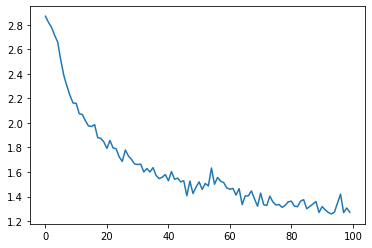

In [30]:
from unicodedata import category


def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i} {i/n_iters} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()    

In [35]:
def predict(input_line):
    print(f"\n {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = rnn.init_hidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

In [37]:
predict("Nahas")


 Nahas
Arabic
